In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from kerastuner.tuners import BayesianOptimization
import pickle
import heapq
import os

In [ ]:
path = '/content/DollsHouse.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 161433


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [ ]:
import nltk
nltk.download('words')
  
def remove_non_vocab_words(words_ls):
    #sentence = nltk.wordpunct_tokenize(sentence)
    res = [x for x in words_ls if x in vocab_words]
    return res

vocab_words = set(nltk.corpus.words.words())
words = remove_non_vocab_words(words)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
unique_words = np.unique(words).tolist()
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [ ]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['the', 'project', 'of', 'a', 'doll']
s


In [ ]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):

    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=50,max_value=250,step=25),\
                   activation='relu', input_shape=(WORD_LENGTH, len(unique_words))))
    
    model.add(Dense(len(unique_words)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(\
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                   metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=5,
    directory='/content/res/',
    project_name='Text Gen')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 250, 'step': 25, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X, Y,epochs=10)

Trial 5 Complete [00h 02m 23s]
accuracy: 0.25599607825279236

Best accuracy So Far: 0.6981061100959778
Total elapsed time: 00h 10m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in /content/res/Text Gen
Showing 10 best trials
Trial summary
Hyperparameters:
units: 125
learning_rate: 0.01
Score: 0.6981061100959778
Trial summary
Hyperparameters:
units: 175
learning_rate: 0.001
Score: 0.25599607825279236
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.001
Score: 0.18344064056873322
Trial summary
Hyperparameters:
units: 125
learning_rate: 0.0001
Score: 0.04680145904421806
Trial summary
Hyperparameters:
units: 75
learning_rate: 0.0001
Score: 0.04156782850623131


In [ ]:
from keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(LSTM(125, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dropout(0.2))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#history = model.fit(X, Y, validation_split=0.1, batch_size=256, epochs=40, shuffle=True).history
history = model.fit(X, Y, batch_size=128, epochs=150, shuffle=True).history

Epoch 1/150
208/208 [==============================] - 3s 7ms/step - loss: 6.1640 - accuracy: 0.0384
Epoch 2/150
208/208 [==============================] - 1s 7ms/step - loss: 5.7398 - accuracy: 0.0401
Epoch 3/150
208/208 [==============================] - 1s 7ms/step - loss: 5.6984 - accuracy: 0.0439
Epoch 4/150
208/208 [==============================] - 1s 6ms/step - loss: 5.6475 - accuracy: 0.0527
Epoch 5/150
208/208 [==============================] - 1s 6ms/step - loss: 5.5643 - accuracy: 0.0590
Epoch 6/150
208/208 [==============================] - 1s 6ms/step - loss: 5.4587 - accuracy: 0.0755
Epoch 7/150
208/208 [==============================] - 1s 6ms/step - loss: 5.3513 - accuracy: 0.0847
Epoch 8/150
208/208 [==============================] - 1s 7ms/step - loss: 5.2452 - accuracy: 0.0974
Epoch 9/150
208/208 [==============================] - 1s 6ms/step - loss: 5.1462 - accuracy: 0.1056
Epoch 10/150
208/208 [==============================] - 1s 6ms/step - loss: 5.0520 - accura

In [ ]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

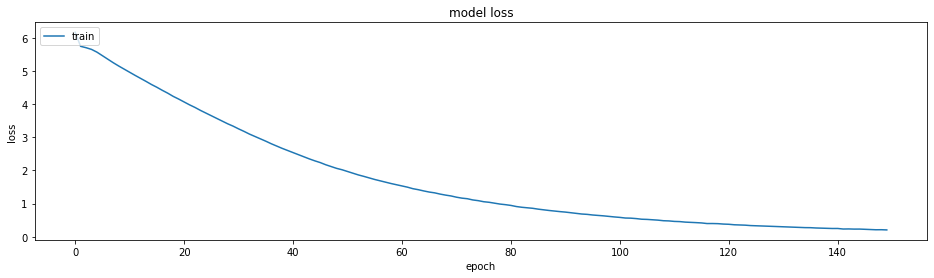

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
test = "he was grasping for"
SEQUENCE_LENGTH = len(test.split())
x = np.zeros((1, WORD_LENGTH, len(unique_words)))    

for t, char in enumerate(test.split()):
        x[0, t, unique_word_index.get(char,np.random.randint(0,len(unique_words)))] = 1.   

In [ ]:
preds = model.predict(x, verbose=0)[0]
preds    

array([1.4914481e-01, 5.8111463e-12, 8.1479739e-09, ..., 9.3069730e-07,
       1.2041421e-15, 4.4073943e-14], dtype=float32)

In [ ]:
next_indices = sample(preds, 10)
next_char = np.array(unique_words)[next_indices]
next_char        

array(['my', 'his', 'a', 'some', 'important', 'letter', 'money', 'in',
       'every', 'three'], dtype='<U15')

In [ ]:
test_sent = ["i was expecting that ","the one that kills us ","could you please step out for "]

for sent in test_sent:

  x = np.zeros((1, WORD_LENGTH, len(unique_words)))    

  for t, char in enumerate(sent.split()):
      if t<WORD_LENGTH:
          x[0, t, unique_word_index.get(char,np.random.randint(0,len(unique_words)))] = 1.   

  preds = model.predict(x, verbose=0)[0]
  next_indices_new = sample(preds, 3)   
  top_3_words = unique_words
  print("Sentence : ",sent)
  print("Top 3 suggestions :",unique_words[next_indices_new[0]],",",unique_words[next_indices_new[1]],",",unique_words[next_indices_new[2]])
  next_char_new = unique_words[next_indices_new[0]]
  gen = sent+next_char_new
  print(gen)     
  print("=======================================") 

Sentence :  i was expecting that 
Top 3 suggestions : it , her , to
i was expecting that it
Sentence :  the one that kills us 
Top 3 suggestions : alone , as , below
the one that kills us alone
Sentence :  could you please step out for 
Top 3 suggestions : with , of , now
could you please step out for with


In [ ]:
test = "let me see if you are"
gen = test

#print(gen)
next_char_new=""
newx = np.zeros((1, 5, len(Y[0])))    
add_words = 3

for i in range(6):
  #print(gen)
  newx = np.zeros((1, 5, len(Y[0])))    
  
  for t, char in enumerate(gen.split()[i+1:]):
  #for t, char in enumerate(gen.split()[i+add_words:]):
        newx[0,t, unique_word_index.get(char)] = 1.   
        
  preds = model.predict(newx, verbose=0)[0]
  next_indices_new = sample(preds, add_words)   
  #print(next_indices_new)
  #for j in range(add_words):
    #next_char_new = unique_words[next_indices_new[j]]
  next_char_new = unique_words[np.random.choice(next_indices_new)]
  gen = gen+" "+next_char_new
  print(gen)
  #print(next_char_new)
  print()  

let me see if you are not

let me see if you are not so

let me see if you are not so anxious

let me see if you are not so anxious to

let me see if you are not so anxious to have

let me see if you are not so anxious to have he

